<a href="https://colab.research.google.com/github/PersonalAlexander/Innopolis/blob/main/Coca_Cola.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **В этом блоке импортируем все, что нам нужно для работы: библиотеки, отдельные функции, сам датасет.**

In [1]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 46.0 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [2]:
# Импорт всех необходимых библиотек
import pandas as pd
import numpy as np
%matplotlib inline

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
data = sm.datasets.sunspots.load_pandas()
from pmdarima import auto_arima 
import seaborn as sns
from tabulate import tabulate
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")




In [3]:
# Подгружаем файл с данными и выводим их
df_original=pd.read_csv('COCO COLA.csv', sep = ';')

df_original.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Week,Понедельник,Вторник,Среда,Четверг,Пятница,Day,Month,Year
0,02/01/1962,0.263021,0.270182,0.263021,0.263021,0.051133,806400,вторник,0,1,0,0,0,2,1,1962
1,03/01/1962,0.259115,0.259115,0.253255,0.257161,0.049994,1574400,среда,0,0,1,0,0,3,1,1962
2,04/01/1962,0.257813,0.261068,0.257813,0.259115,0.050374,844800,четверг,0,0,0,1,0,4,1,1962
3,05/01/1962,0.259115,0.262370,0.252604,0.253255,0.049234,1420800,пятница,0,0,0,0,1,5,1,1962
4,08/01/1962,0.251302,0.251302,0.245768,0.250651,0.048728,2035200,понедельник,1,0,0,0,0,8,1,1962


In [4]:
# Рабочая копия оригинального датасета
df=df_original

In [5]:
# Выводим список колонок в датафрейме и проверяем на пустые значения
def columnValues(df):
    row = [df.nunique(), (df == 0).sum(axis=0), df.isna().sum(), round(df.isna().sum() / len(df) * 100, 1), df.dtypes]
    return row

data = []
for column in df:
    data.append([column] + columnValues(df[column]))

print(tabulate(data, headers=['Column', 'Count Unique', 'Count Zeros', 'Count NaNs','% of NaNs', 'data type'], tablefmt='orgtbl'))

| Column      |   Count Unique |   Count Zeros |   Count NaNs |   % of NaNs | data type   |
|-------------+----------------+---------------+--------------+-------------+-------------|
| Date        |          15096 |             0 |            0 |           0 | object      |
| Open        |           5261 |             0 |            0 |           0 | float64     |
| High        |           5309 |             0 |            0 |           0 | float64     |
| Low         |           5249 |             0 |            0 |           0 | float64     |
| Close       |           5412 |             0 |            0 |           0 | float64     |
| Adj Close   |          10893 |             0 |            0 |           0 | float64     |
| Volume      |          10188 |             0 |            0 |           0 | int64       |
| Week        |              5 |             0 |            0 |           0 | object      |
| Понедельник |              2 |         12214 |            0 |           0 | in

In [6]:
## Кол-во строк и столбцов таблицы 
df.shape

(15096, 16)

Выводы по разделу: Датасет содержит 15096 записей, 16 колонок , тип переменных -float64, int64, object.
В данных нет NaN значений.

# **Предобработка данных**

In [7]:
# Добавляем колонку Year
df['Year']=pd.to_datetime(df['Date'], format="%d/%m/%Y")

In [8]:
# Индексируем колонку Year
df.set_index('Year', inplace=True)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Week,Понедельник,Вторник,Среда,Четверг,Пятница,Day,Month
Year,,,,,,,,,,,,,,,
1962-01-02,02/01/1962,0.263021,0.270182,0.263021,0.263021,0.051133,806400,вторник,0,1,0,0,0,2,1
1962-01-03,03/01/1962,0.259115,0.259115,0.253255,0.257161,0.049994,1574400,среда,0,0,1,0,0,3,1
1962-01-04,04/01/1962,0.257813,0.261068,0.257813,0.259115,0.050374,844800,четверг,0,0,0,1,0,4,1
1962-01-05,05/01/1962,0.259115,0.262370,0.252604,0.253255,0.049234,1420800,пятница,0,0,0,0,1,5,1
1962-01-08,08/01/1962,0.251302,0.251302,0.245768,0.250651,0.048728,2035200,понедельник,1,0,0,0,0,8,1


In [9]:
# Добавляем новую колонку Avg, со средним значением цены за акцию
df['Avg'] = df[['High','Low',]].sum(axis=1)/2

In [10]:
# Удаляем колонку Week
df = df.drop(columns=['Week'])

In [11]:
# Переименовываем столбцы
df.rename(columns = {'Понедельник':'Mon', 'Вторник':'Tue', 'Среда':'Wed', 'Четверг':'Thu','Пятница':'Fri'}, inplace = True )
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Mon,Tue,Wed,Thu,Fri,Day,Month,Avg
Year,,,,,,,,,,,,,,,
1962-01-02,02/01/1962,0.263021,0.270182,0.263021,0.263021,0.051133,806400,0,1,0,0,0,2,1,0.266601
1962-01-03,03/01/1962,0.259115,0.259115,0.253255,0.257161,0.049994,1574400,0,0,1,0,0,3,1,0.256185
1962-01-04,04/01/1962,0.257813,0.261068,0.257813,0.259115,0.050374,844800,0,0,0,1,0,4,1,0.259441
1962-01-05,05/01/1962,0.259115,0.262370,0.252604,0.253255,0.049234,1420800,0,0,0,0,1,5,1,0.257487
1962-01-08,08/01/1962,0.251302,0.251302,0.245768,0.250651,0.048728,2035200,1,0,0,0,0,8,1,0.248535


In [13]:
df.loc["01/01/2018":].head()

,Date,Open,High,Low,Close,Adj Close,Volume,Mon,Tue,Wed,Thu,Fri,Day,Month,Avg
Year,,,,,,,,,,,,,,,
2018-01-02,02/01/2018,45.910000,45.939999,45.509998,45.540001,39.993103,10872200,0,1,0,0,0,2,1,45.724998
2018-01-03,03/01/2018,45.490002,45.689999,45.340000,45.439999,39.905273,12635600,0,0,1,0,0,3,1,45.515000
2018-01-04,04/01/2018,45.560001,46.220001,45.450001,46.080002,40.467323,12709400,0,0,0,1,0,4,1,45.835001
2018-01-05,05/01/2018,46.020000,46.200001,45.790001,46.070000,40.458538,13113100,0,0,0,0,1,5,1,45.995001
2018-01-08,08/01/2018,45.950001,46.099998,45.880001,46.000000,40.397076,7068600,1,0,0,0,0,8,1,45.989999


### **EDA или разведочный анализ данных.**

In [ ]:
#Выбираем диапазон с 2018 года
df.loc["01/01/2018":].shape

(999, 15)

In [ ]:
df.loc["01/01/2018":][['Open','High','Low', 'Close', 'Adj Close', 'Volume']].describe()

,Open,High,Low,Close,Adj Close,Volume
count,999.000000,999.000000,999.000000,999.000000,999.000000,9.990000e+02
mean,50.013373,50.380691,49.623183,49.997147,46.926756,1.458007e+07
std,4.438846,4.422343,4.472866,4.460165,5.484225,6.822520e+06
min,38.759998,38.889999,36.270000,37.560001,35.516018,3.265500e+06
25%,46.225001,46.545000,45.914999,46.180000,42.105574,1.050780e+07
50%,49.610001,50.000000,49.270000,49.650002,47.192211,1.299140e+07
75%,54.009998,54.365000,53.720001,53.970000,51.448040,1.651305e+07
max,59.810001,60.130001,59.619999,60.130001,58.650002,6.784570e+07


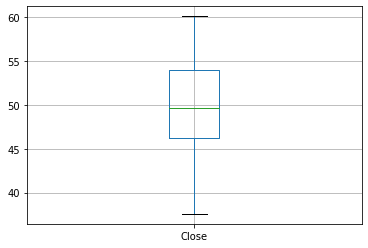

In [ ]:
# Строим график распределения вероятностей.
df.loc["01/01/2018":].boxplot(column='Close')



[Text(0, 0.5, 'Price $'), Text(0.5, 0, 'Year')]

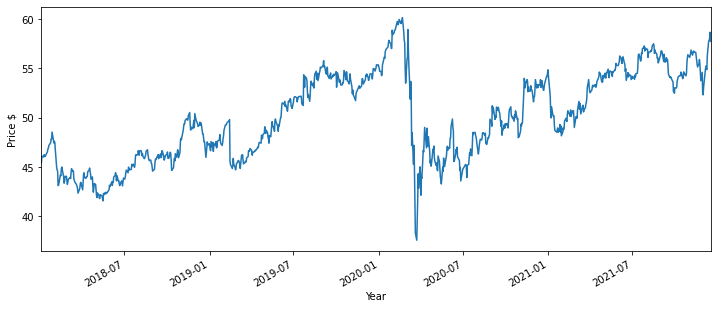

In [ ]:
# Строим график
xtitle='----'
ylabel='Price $'
xlabel='Year'

ax=df.loc["01/01/2018":]['Close'].plot(figsize=(12,5))
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

In [ ]:
import plotly.express as px
fig=px.line(df.loc["01/01/2018":], x='Date', y='Close', title="Цена акций Coca-Cola" )
fig.show()

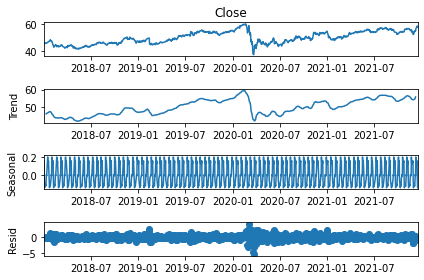

In [ ]:
# ETS декомпозиция
decomp = seasonal_decompose(df.loc["01/01/2018":]['Close'], period=12)

decomp.plot();
plt.tight_layout();

## **Построение моделей, анализ результатов.**

# Модель ARIMA.

Наиболее популярная модель для прогноза временных рядов -ARIMA Описание модели :ARIMA описывает корреляцию между точками данных и учитывает разницу значений. ARIMA использует три основных параметра (p, d, q).Эти три параметра учитывают сезонность, тенденцию и шум в наборах данных. AR (авторегрессия)-p, I (разность) -d и MA (скользящая средняя)-q. При построении модели будем использовать метод Auto ARIMA для определения значения p d q.

In [ ]:
# Делим данные на тренировочный и тестовый наборы
train=df.loc["01/02/2018":"11/29/2021"]['Close']
test=df.loc["11/30/2021":]['Close']

In [ ]:
len(df["01/01/2018":]['Close'])

999

In [ ]:
# Расчет параметров
auto_arima(df.loc["01/01/2018":]['Close'],seasonal=True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  999
Model:             SARIMAX(1, 1, 4)x(1, 0, [], 12)   Log Likelihood               -1008.878
Date:                             Wed, 08 Feb 2023   AIC                           2031.755
Time:                                     17:26:08   BIC                           2066.096
Sample:                                          0   HQIC                          2044.808
                                             - 999                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7521      0.034    -21.859      0.000      -0.820      -0.685
ma.L1          0.7427      0.039     19.145      0.000       0.667       0.819
ma.L2          0.0339      0.022      1.563      0.118      -0.009       0.076
ma.L3          0.0204      0.025      0.821      0.412      -0.028       0.069
ma.L4         -0.1502      0.022     -6.760      0.000      -0.194      -0.107
ar.S.L12      -0.0778      0.022     -3.528      0.000      -0.121      -0.035
sigma2         0.4420      0.010     45.372      0.000       0.423       0.461
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              3086.99
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               1.38   Skew:                            -0.93
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Строим и обучаем модель
model=SARIMAX(train,order=(1, 1, 4),seasonal_order=(1, 0, [], 12))
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Close   No. Observations:                  985
Model:             SARIMAX(1, 1, 4)x(1, 0, [], 12)   Log Likelihood                -988.044
Date:                             Wed, 08 Feb 2023   AIC                           1990.088
Time:                                     17:30:00   BIC                           2024.329
Sample:                                          0   HQIC                          2003.112
                                             - 985                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7561      0.034    -22.387      0.000      -0.822      -0.690
ma.L1          0.7445      0.038     19.555      0.000       0.670       0.819
ma.L2          0.0295      0.022      1.370      0.171      -0.013       0.072
ma.L3          0.0115      0.025      0.463      0.643      -0.037       0.060
ma.L4         -0.1544      0.022     -7.021      0.000      -0.198      -0.111
ar.S.L12      -0.0754      0.022     -3.463      0.001      -0.118      -0.033
sigma2         0.4360      0.010     45.631      0.000       0.417       0.455
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              3320.21
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                            -0.96
Prob(H) (two-sided):                  0.03   Kurtosis:                        11.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

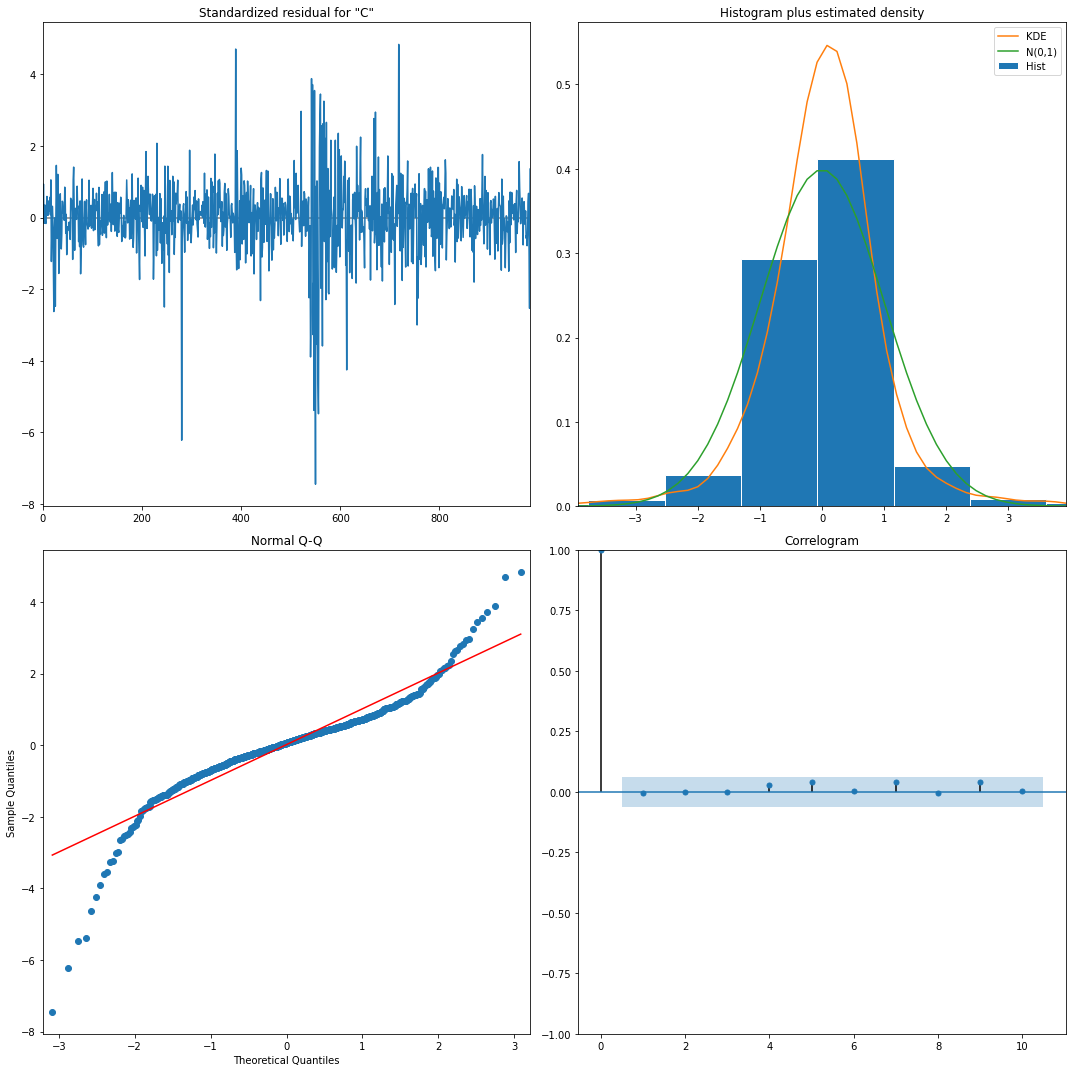

In [ ]:
results.plot_diagnostics(figsize=(15, 15));
plt.tight_layout();

In [ ]:
predictions =results.predict().rename('SARIMAX(1, 1, 4)x1, 0, [], 12)')

In [ ]:
# Делаем прогноз значений на основании построенной модели
for i in range(len(predictions)):
 print(f"предсказанное значение={predictions[i]:<11.10}, текущее значение в выборке ={train[i]}") 

предсказанное значение=0.0        , текущее значение в выборке =45.540001
предсказанное значение=45.54000005, текущее значение в выборке =45.439999
предсказанное значение=45.4445365 , текущее значение в выборке =46.080002
предсказанное значение=46.04703555, текущее значение в выборке =46.07
предсказанное значение=46.10783796, текущее значение в выборке =46.0
предсказанное значение=45.99472691, текущее значение в выборке =46.23
предсказанное значение=46.13008581, текущее значение в выборке =46.07
предсказанное значение=46.14996406, текущее значение в выборке =46.040001
предсказанное значение=45.99931331, текущее значение в выборке =46.150002
предсказанное значение=46.13543394, текущее значение в выборке =46.529999
предсказанное значение=46.54530113, текущее значение в выборке =46.82
предсказанное значение=46.83940999, текущее значение в выборке =46.880001
предсказанное значение=46.8507873 , текущее значение в выборке =47.16
предсказанное значение=47.1232203 , текущее значение в выборке 

[Text(0, 0.5, 'Price $'), Text(0.5, 0, 'Year')]

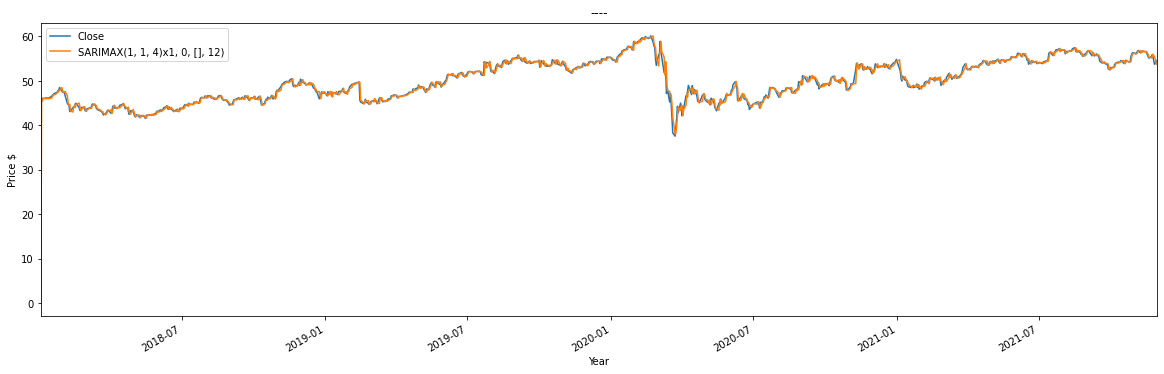

In [ ]:
#Получаем прогнозируемые значения и строим графики прогнозируемых и известных значений
xtitle='----'
ylabel='Price $'
xlabel='Year'
ax=train.plot(legend=True, figsize=(20,6), title=xtitle)
predictions.plot(legend=True) 


ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

In [ ]:
#Оцениваем качество модели с помощью MSE и RMSE.
from sklearn.metrics import mean_squared_error
mse_value=mean_squared_error(train,predictions)

from statsmodels.tools.eval_measures  import rmse
rmse_value=rmse(train,predictions)

print(f'SARIMAX(1, 1, 4)x1, 0, [], 12) MSE Error:{mse_value:11.10}')
print(f'SARIMAX(1, 1, 4)x1, 0, [], 12) RMSE Error:{rmse_value:11.10}')


SARIMAX(1, 1, 4)x1, 0, [], 12) MSE Error:2.541084295
SARIMAX(1, 1, 4)x1, 0, [], 12) RMSE Error:1.594077882


In [ ]:
# Cтроим прогноз на следующие 14 наблюдений
model=SARIMAX(test,order=(1, 1, 4),seasonal_order=(1, 0, [], 12))
results=model.fit()

fcast=results.predict(len(test)-1, len(test)+14, type = 'levels').rename('SARIMAX(1, 1, 4)x1, 0, [], 12)')
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Close   No. Observations:                   14
Model:             SARIMAX(1, 1, 4)x(1, 0, [], 12)   Log Likelihood                 -13.164
Date:                             Sun, 05 Feb 2023   AIC                             40.328
Time:                                     14:57:23   BIC                             44.283
Sample:                                 11-30-2021   HQIC                            39.515
                                      - 12-17-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8232      1.642      0.501      0.616      -2.394       4.041
ma.L1         -0.8169     17.356     -0.047      0.962     -34.834      33.200
ma.L2         -0.3294      1.959     -0.168      0.866      -4.168       3.509
ma.L3          0.1863      9.753      0.019      0.985     -18.929      19.302
ma.L4          0.4126      7.274      0.057      0.955     -13.845      14.670
ar.S.L12       0.7252      3.668      0.198      0.843      -6.464       7.914
sigma2         0.1966      2.656      0.074      0.941      -5.008       5.402
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.82
Prob(Q):                              0.99   Prob(JB):                         0.66
Heteroskedasticity (H):               1.21   Skew:                            -0.56
Prob(H) (two-sided):                  0.86   Kurtosis:                         3.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

[Text(0, 0.5, 'Price $'), Text(0.5, 0, 'Date')]

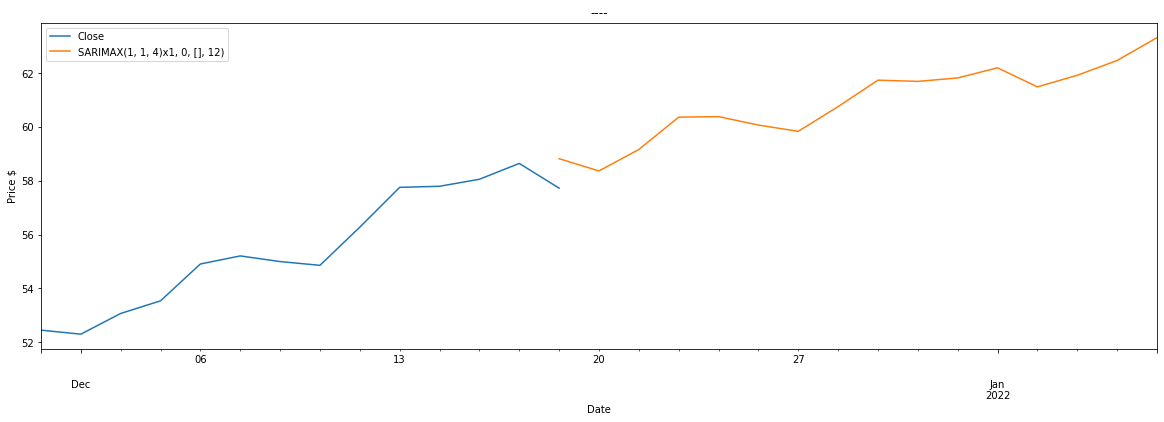

In [ ]:
# Строим график предсказаных значений
xtitle='----'
ylabel='Price $'
xlabel='Date'

ax=test.plot(legend=True, figsize=(20,6), title=xtitle)
fcast.plot(legend=True)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
